# GRID GENERATION

### The following one

In [88]:
import numpy as np
from Bio import PDB
import copy as cp
# Define grid parameters
grid_size = 1.0  # Angstrom resolution
border = 5.0  # Extra space around the protein

# Load the PDB file
pdb_parser = PDB.PDBParser(QUIET=True)
structure = pdb_parser.get_structure("1ppb", "1ppb.pdb")

# Extract atomic coordinates
coords = []
for atom in structure.get_atoms():
    coords.append(atom.coord)

coords = np.array(coords)

# Define grid boundaries
x_min, y_min, z_min = np.min(coords, axis=0) - border
x_max, y_max, z_max = np.max(coords, axis=0) + border

x_bins = int((x_max - x_min) / grid_size) + 1
y_bins = int((y_max - y_min) / grid_size) + 1
z_bins = int((z_max - z_min) / grid_size) + 1

prot_grid = np.zeros((x_bins, y_bins, z_bins))
pocket_grid = cp.deepcopy(prot_grid)

print("Grid shape:", prot_grid.shape)
print("Grid shape:", pocket_grid.shape)

Grid shape: (65, 67, 66)
Grid shape: (65, 67, 66)


# Projecting the protein

### The following one

In [89]:
VDW_RADII = {
    "H": 1.1,  # Hydrogen
    "C": 1.6,  # Carbon
    "N": 1.45, # Nitrogen
    "O": 1.42, # Oxygen
    "S": 1.7   # Sulfur (only in Cys & Met)
}

def atom_range(x, y, z, radius):
    """Computes the voxel range occupied by an atom based on its radius."""
    neg_direction = [
        int(round((x - radius - x_min) / grid_size)),  # x-axis
        int(round((y - radius - y_min) / grid_size)),  # y-axis
        int(round((z - radius - z_min) / grid_size))   # z-axis
    ]
    pos_direction = [
        int(round((x + radius - x_min) / grid_size)),  # x-axis
        int(round((y + radius - y_min) / grid_size)),  # y-axis
        int(round((z + radius - z_min) / grid_size))   # z-axis
    ]

    # Ensure indices are within grid bounds
    neg_direction = [max(0, neg_direction[i]) for i in range(3)]
    pos_direction = [min((x_bins, y_bins, z_bins)[i] - 1, pos_direction[i]) for i in range(3)]

    return neg_direction, pos_direction

# Loop through all atoms and mark their occupied voxels
for atom in structure.get_atoms():
    # Check to ensue we are only looking at protein atoms
    residue = atom.get_parent()
    if residue.id[0] == " ":
        x, y, z = atom.coord
        neg, pos = atom_range(x, y, z, VDW_RADII.get(atom.element, 1.6))

            # Iterate over affected voxel range
        for i in range(neg[0], pos[0] + 1):
            for j in range(neg[1],pos[1] + 1):
                for k in range(neg[2], pos[2] + 1):
                    prot_grid[i, j, k] = 1  # Mark voxel as occupied
print("Grid shape:", prot_grid.shape)

Grid shape: (65, 67, 66)


### No, just testing

In [75]:
num_occupied_voxels = np.count_nonzero(prot_grid)
print(f"Number of occupied voxels: {num_occupied_voxels}")
occupied_indices = np.argwhere(prot_grid == 1)
print(f"First 10 occupied grid points:\n{occupied_indices[:10]}")

Number of occupied voxels: 48620
First 10 occupied grid points:
[[ 4 34 43]
 [ 4 34 44]
 [ 4 34 45]
 [ 4 34 46]
 [ 4 35 43]
 [ 4 35 44]
 [ 4 35 45]
 [ 4 35 46]
 [ 4 36 43]
 [ 4 36 44]]


### No, just testing

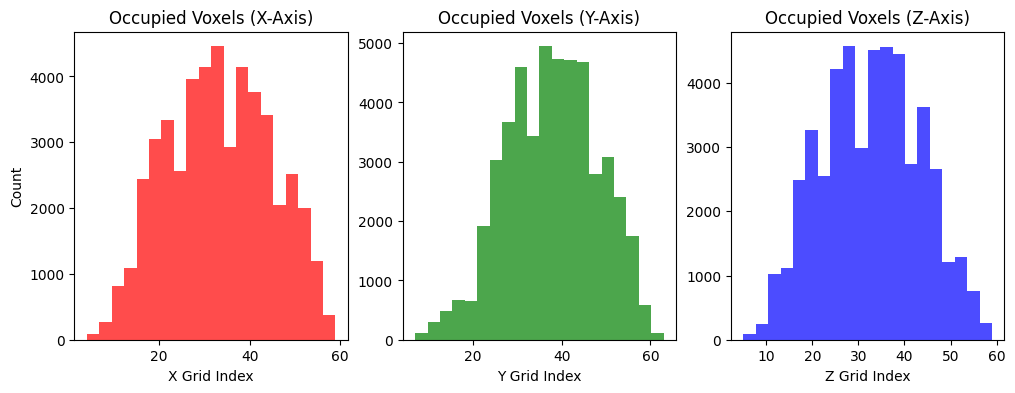

In [76]:
import matplotlib.pyplot as plt

x_coords, y_coords, z_coords = occupied_indices.T  # Transpose to split into x, y, z
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(x_coords, bins=20, color='red', alpha=0.7)
plt.xlabel('X Grid Index')
plt.ylabel('Count')
plt.title('Occupied Voxels (X-Axis)')

plt.subplot(1, 3, 2)
plt.hist(y_coords, bins=20, color='green', alpha=0.7)
plt.xlabel('Y Grid Index')
plt.title('Occupied Voxels (Y-Axis)')

plt.subplot(1, 3, 3)
plt.hist(z_coords, bins=20, color='blue', alpha=0.7)
plt.xlabel('Z Grid Index')
plt.title('Occupied Voxels (Z-Axis)')

plt.show()


### No, just testing

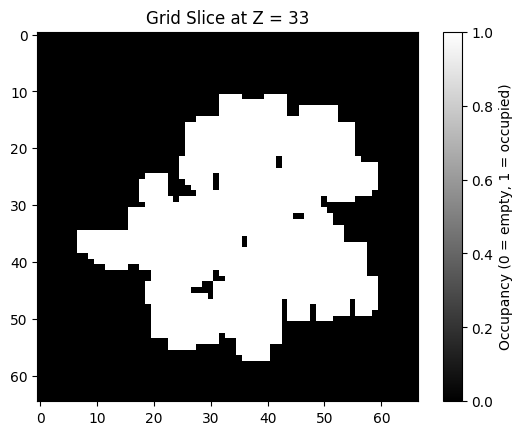

In [77]:
z_slice = prot_grid.shape[2] // 2  # Take a middle slice along Z
plt.imshow(prot_grid[:, :, z_slice], cmap='gray')
plt.colorbar(label="Occupancy (0 = empty, 1 = occupied)")
plt.title(f"Grid Slice at Z = {z_slice}")
plt.show()

### No, just testing

In [78]:
def map_to_grid(x, y, z):
    """Converts atomic coordinates (x, y, z) to grid indices (i, j, k)."""
    i = int(round((x - x_min) / grid_size))  # Convert x to grid index
    j = int(round((y - y_min) / grid_size))  # Convert y to grid index
    k = int(round((z - z_min) / grid_size))  # Convert z to grid index
    return i, j, k

for atom in structure.get_atoms():
    x, y, z = atom.coord
    i, j, k = map_to_grid(x, y, z)

    if prot_grid[i, j, k] == 1:
        print(f"✅ Atom {atom.element} at ({x:.2f}, {y:.2f}, {z:.2f}) → Grid ({i}, {j}, {k}) ✅")
    else:
        print(f"❌ Atom {atom.element} at ({x:.2f}, {y:.2f}, {z:.2f}) was NOT projected correctly ❌")
        break  # Stop early if we find a missing atom


✅ Atom N at (-9.00, 48.93, 19.25) → Grid (23, 60, 25) ✅
✅ Atom C at (-8.11, 49.10, 20.38) → Grid (24, 60, 26) ✅
✅ Atom C at (-8.05, 47.62, 20.79) → Grid (24, 58, 26) ✅
✅ Atom O at (-7.58, 46.90, 19.93) → Grid (25, 58, 26) ✅
✅ Atom C at (-8.73, 50.22, 21.33) → Grid (24, 61, 27) ✅
✅ Atom O at (-7.63, 50.65, 22.12) → Grid (25, 61, 28) ✅
✅ Atom C at (-9.92, 49.82, 22.21) → Grid (23, 61, 28) ✅
✅ Atom N at (-8.60, 46.98, 21.82) → Grid (24, 58, 28) ✅
✅ Atom C at (-7.84, 46.07, 22.66) → Grid (25, 57, 28) ✅
✅ Atom C at (-8.26, 44.59, 22.59) → Grid (24, 55, 28) ✅
✅ Atom O at (-7.51, 43.73, 23.04) → Grid (25, 55, 29) ✅
✅ Atom C at (-8.11, 46.78, 23.99) → Grid (24, 58, 30) ✅
✅ Atom C at (-7.52, 46.39, 25.34) → Grid (25, 57, 31) ✅
✅ Atom C at (-6.26, 45.81, 25.49) → Grid (26, 57, 31) ✅
✅ Atom C at (-8.30, 46.70, 26.44) → Grid (24, 58, 32) ✅
✅ Atom C at (-5.81, 45.55, 26.77) → Grid (27, 56, 32) ✅
✅ Atom C at (-7.84, 46.43, 27.71) → Grid (25, 57, 33) ✅
✅ Atom C at (-6.59, 45.86, 27.87) → Grid (26, 57

# PSP detection

### The following one

In [90]:
directions = [
    # Axial directions (6)
    np.array([1, 0, 0]), np.array([-1, 0, 0]), np.array([0, 1, 0]), np.array([0, -1, 0]), np.array([0, 0, 1]), np.array([0, 0, -1]),
    
    # Cubic diagonals (8)
    np.array([1, 1, 1]), np.array([1, 1, -1]), np.array([1, -1, 1]), np.array([1, -1, -1]),
    np.array([-1, 1, 1]), np.array([-1, 1, -1]), np.array([-1, -1, 1]), np.array([-1, -1, -1])
]

def axial(grid_prot, grid_count, axis, directions, i, j, k):
    if axis == "x":
        dir = directions[0:2]
        mod = 0
        top = x_bins
    elif axis == "y":
        dir = directions[2:4]
        mod = 1
        top = y_bins
    elif axis == "z":
        dir = directions[4:6]
        mod = 2
        top = z_bins
    coord_pos = np.array([i, j, k])
    coord_neg = np.array([i, j, k])
    prot_found_pos = False
    prot_found_neg = False
    while prot_found_pos == False and coord_pos[mod] < top-1:
        coord_pos += dir[0]
        if grid_prot[coord_pos[0], coord_pos[1], coord_pos[2]] == 1:
            prot_found_pos = True
            break
    while prot_found_neg == False and coord_neg[mod] > 0:
        coord_neg += dir[1]
        if grid_prot[coord_neg[0], coord_neg[1], coord_neg[2]] == 1:
            prot_found_neg = True
            break 
    if prot_found_neg and prot_found_pos:
        grid_count[i, j, k] += 1 

def diagonal(grid_prot, grid_count, plane, directions, i, j, k):
    if plane == "xy":
        dir = directions[14:18]
        mod = [0, 1]
        top = [x_bins, y_bins]
    elif plane == "yz":
        dir = directions[18:22]
        mod = [1, 2]
        top = [y_bins, z_bins]
    elif plane == "xz":
        dir = directions[22:]
        mod = [0, 2]
        top = [x_bins, z_bins]
    same_sign_coord_pos = np.array([i, j, k])
    same_sign_coord_neg = np.array([i, j, k])
    diff_sign_coord1 = np.array([i, j, k])
    diff_sign_coord2 = np.array([i, j, k])
    pf_same_pos, pf_same_neg, pf_diff1, pf_diff2 = False, False, False, False
    # Same sign
    while pf_same_pos == False and same_sign_coord_pos[mod[0]] < top[0]-1 and same_sign_coord_pos[mod[1]] < top[1]-1:
        same_sign_coord_pos += dir[0]
        if grid_prot[same_sign_coord_pos[0], same_sign_coord_pos[1], same_sign_coord_pos[2]] == 1:
            pf_same_pos = True
            break
    while pf_same_neg == False and same_sign_coord_neg[mod[0]] > 0 and same_sign_coord_neg[mod[1]] > 0:
        same_sign_coord_neg += dir[3]
        if grid_prot[same_sign_coord_neg[0], same_sign_coord_neg[1], same_sign_coord_neg[2]] == 1:
            pf_same_neg = True
            break 
    if pf_same_neg and pf_same_pos:
        grid_count[i, j, k] += 1
    # Diff sign
    while pf_diff1 == False and diff_sign_coord1[mod[0]] < top[0]-1 and diff_sign_coord1[mod[1]] > 0:
        diff_sign_coord1 += dir[1]
        if grid_prot[diff_sign_coord1[0], diff_sign_coord1[1], diff_sign_coord1[2]] == 1:
            pf_diff1 = True
            break
    while pf_diff2 == False and diff_sign_coord2[mod[0]] > 0 and diff_sign_coord2[mod[1]] < top[1]-1:
        diff_sign_coord2 += dir[2]
        if grid_prot[diff_sign_coord2[0], diff_sign_coord2[1], diff_sign_coord2[2]] == 1:
            pf_diff2 = True
            break 
    if pf_diff1 and pf_diff2:
        grid_count[i, j, k] += 1

def cubic_diagonals(grid_prot, grid_count, directions, i , j, k):
    pos_pos_pos = np.array([i, j, k])
    neg_neg_neg = np.array([i, j, k])
    neg_pos_pos = np.array([i, j, k])
    pos_neg_neg = np.array([i, j, k])
    pos_neg_pos = np.array([i, j, k])
    neg_pos_neg = np.array([i, j, k])
    pos_pos_neg = np.array([i, j, k])
    neg_neg_pos = np.array([i, j, k])
    ppp, nnn, npp, pnn, pnp, npn, ppn, nnp = False, False, False, False, False, False, False, False
    # All positive and all negative
    while ppp == False and pos_pos_pos[0] < x_bins-1 and pos_pos_pos[1] < y_bins-1 and pos_pos_pos[2] < z_bins-1:
        pos_pos_pos += directions[6]
        if grid_prot[pos_pos_pos[0], pos_pos_pos[1], pos_pos_pos[2]] == 1:
            ppp = True
            break
    while nnn == False and neg_neg_neg[0] > 0 and neg_neg_neg[1] > 0 and neg_neg_neg[2] > 0:
        neg_neg_neg += directions[13]
        if grid_prot[neg_neg_neg[0], neg_neg_neg[1], neg_neg_neg[2]] == 1:
            nnn = True
            break 
    if ppp and nnn:
        grid_count[i, j, k] += 1
                    
    # x axis different
    while npp == False and neg_pos_pos[0] > 0 and neg_pos_pos[1] < y_bins-1 and neg_pos_pos[2] < z_bins-1:
        neg_pos_pos += directions[10]
        if grid_prot[neg_pos_pos[0], neg_pos_pos[1], neg_pos_pos[2]] == 1:
            npp = True
            break
    while pnn == False and pos_neg_neg[0] < x_bins-1 and pos_neg_neg[1] > 0 and pos_neg_neg[2] > 0:
        pos_neg_neg += directions[9]
        if grid_prot[pos_neg_neg[0], pos_neg_neg[1], pos_neg_neg[2]] == 1:
            pnn = True
            break 
    if npp and pnn:
        grid_count[i, j, k] += 1
                    
    # y axis different
    while pnp == False and pos_neg_pos[0] < x_bins-1 and pos_neg_pos[1] > 0 and pos_neg_pos[2] < z_bins-1:
        pos_neg_pos += directions[8]
        if grid_prot[pos_neg_pos[0], pos_neg_pos[1], pos_neg_pos[2]] == 1:
            pnp = True
            break
    while npn == False and neg_pos_neg[0] > 0 and neg_pos_neg[1] < y_bins-1 and neg_pos_neg[2] > 0:
        neg_pos_neg += directions[11]
        if grid_prot[neg_pos_neg[0], neg_pos_neg[1], neg_pos_neg[2]] == 1:
            npn = True
            break 
    if pnp and npn:
        grid_count[i, j, k] += 1
                    
    # z axis different
    while ppn == False and pos_pos_neg[0] < x_bins-1 and pos_pos_neg[1] < y_bins-1 and pos_pos_neg[2] > 0:
        pos_pos_neg += directions[7]
        if grid_prot[pos_pos_neg[0], pos_pos_neg[1], pos_pos_neg[2]] == 1:
            ppn = True
            break
    while nnp == False and neg_neg_pos[0] > 0 and neg_neg_pos[1] > 0 and neg_neg_pos[2] < z_bins-1:
        neg_neg_pos += directions[12]
        if grid_prot[neg_neg_pos[0], neg_neg_pos[1], neg_neg_pos[2]] == 1:
            nnp = True
            break 
    if ppn and nnp:
        grid_count[i, j, k] += 1

def PSP_search(grid_prot, grid_count, directions, diagonals=False):
    if diagonals:
        directions.extend([
            # XY plane (4)
            np.array([1, 1, 0]), np.array([1, -1, 0]), np.array([-1, 1, 0]), np.array([-1, -1, 0]),
            # YZ plane (4)
            np.array([0, 1, 1]), np.array([0, 1, -1]), np.array([0, -1, 1]), np.array([0, -1, -1]),
            # XZ plane (4)
            np.array([1, 0, 1]), np.array([1, 0, -1]), np.array([-1, 0, 1]), np.array([-1, 0, -1])
        ])
    for i in range(x_bins):
        for j in range(y_bins):
            for k in range(z_bins):
                if grid_prot[i, j, k] == 0 and 0 < i < x_bins-1 and 0 < j < y_bins-1 and 0 < k < z_bins-1:
                    axial(grid_prot, grid_count, "x", directions, i, j, k)
                    axial(grid_prot, grid_count, "y", directions, i, j, k)
                    axial(grid_prot, grid_count, "z", directions, i, j, k)
                    if diagonals:
                        diagonal(grid_prot, grid_count, "xy", directions, i, j, k)
                        diagonal(grid_prot, grid_count, "yz", directions, i, j, k)
                        diagonal(grid_prot, grid_count, "xz", directions, i, j, k)
                    cubic_diagonals(grid_prot, grid_count, directions, i, j, k)

PSP_search(prot_grid, pocket_grid, directions, diagonals=True)

### No, just testing

In [80]:
if np.any(pocket_grid > 0):
    print("✅ Pocket grid contains nonzero values (pockets detected).")
else:
    print("❌ Pocket grid is empty (no pockets detected).")

✅ Pocket grid contains nonzero values (pockets detected).


### No, just testing

In [81]:
nonzero_count = np.count_nonzero(pocket_grid)
unique_values = np.unique(pocket_grid)

print(f"🔍 Pocket grid contains {nonzero_count} nonzero points.")
print(f"🧐 Unique values found in pocket grid: {unique_values}")

🔍 Pocket grid contains 17678 nonzero points.
🧐 Unique values found in pocket grid: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


### No, just testing

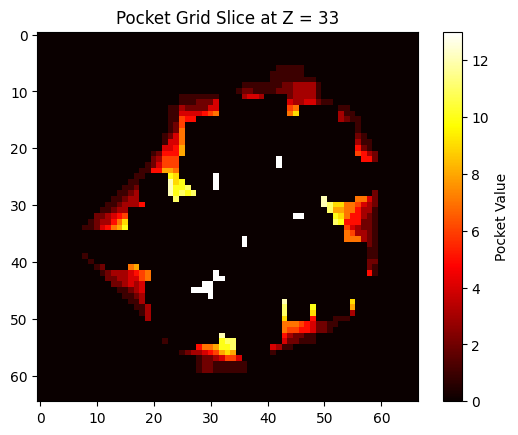

In [82]:
import matplotlib.pyplot as plt

slice_index = pocket_grid.shape[2] // 2  # Take a middle slice along Z-axis
plt.imshow(pocket_grid[:, :, slice_index], cmap="hot", interpolation="nearest")
plt.colorbar(label="Pocket Value")
plt.title(f"Pocket Grid Slice at Z = {slice_index}")
plt.show()


# Detection and clustering of pockets

### The following code

In [91]:
# objects that will store the pockets and their score
pockets=[]
scores=[]

# function to get the pockets and scores
def detect_pockets(grid_pock, pockets, scoring, diagonals=False, cutoff=4):
    """Save detected pocket sites to a PDB file."""
    # first, we get all grid points that have a value over a certain cut-off
    filtered_grid_points=[]
    for i in range(grid_pock.shape[0]):
        for j in range(grid_pock.shape[1]):
            for k in range(grid_pock.shape[2]):
                if grid_pock[i, j, k] > cutoff:
                    filtered_grid_points.append([i, j, k])
    # depending on whether diagonals have been taken into account, the maximum value can be 13 or 7, this value will be used later
    if diagonals:
        top= 13
    else:
        top= 7
    
    # cluster the grid points into pockets
    while len(filtered_grid_points) != 0:
        # we will take the first point and see which are next to it, wew ill also save its score
        pocket=[filtered_grid_points[0]]
        score=[int(grid_pock[filtered_grid_points[0][0], filtered_grid_points[0][1], filtered_grid_points[0][2]])]
        # for each point in pocket, already there or added witht this loop, we will check if we have a contiguous point in the list of filtered gird points
        for point in pocket:
            for gp in filtered_grid_points:
                # basically I move in one axis, I move one place in the x-axis mantaining the position in the y and z; and same logic for y-axis and z-axis; then check if the point is present in our list
                if (point[0]-1 == gp[0] and point[1]== gp[1] and point[2]==gp[2]) or (point[0]+1 == gp[0] and point[1]== gp[1] and point[2] ==gp[2]) or (point[0] == gp[0] and point[1]-1 == gp[1] and point[2]==gp[2]) or (point[0] == gp[0] and point[1]+1 == gp[1] and point[2]==gp[2]) or (point[0] == gp[0] and point[1]== gp[1] and point[2]-1 ==gp[2]) or (point[0] == gp[0] and point[1]== gp[1] and point[2]+1 ==gp[2]):
                    # to avoid repetitions, if the grid point found is already in pocket, it will not be added
                    if gp not in pocket:
                        # if it is a new grid point, we add the grid point to pocket so that the next iteration can look for contiguous points to this grid_point 
                        pocket.append(gp)
                        score.append(int(grid_pock[gp[0], gp[1], gp[2]]))
        # once we have the complete pocket, as the first point is obtained taking the first point in the filtered list, we remove those points already assigned to a pocket
        temp_filtered_grid_points = [gpoint for gpoint in filtered_grid_points if gpoint not in pocket]
        filtered_grid_points=temp_filtered_grid_points
        # make sure that the pocket we have found is not actually a cavity, we detect cavities following the logic that cavities will have all their grid points with the maximum socre. Therefore, we check if the set of scores equals a set of just the maximum score
        if set(score) != {top}:
            pockets.append(pocket)
            scoring.append(score)
# execute the function
detect_pockets(pocket_grid, pockets, scores, diagonals= True)
print(pockets)
print(scores)

[[[9, 36, 42], [9, 36, 43], [9, 37, 42], [9, 37, 41], [9, 38, 42], [10, 38, 42], [11, 38, 42], [11, 38, 41], [12, 38, 42], [11, 38, 40], [12, 38, 41], [12, 39, 42], [13, 38, 42], [11, 37, 40], [12, 38, 40], [12, 39, 41], [13, 39, 42], [10, 37, 40], [11, 37, 39], [12, 37, 40], [12, 38, 39], [12, 39, 40], [13, 40, 42], [10, 37, 39], [11, 37, 38], [12, 37, 39], [12, 38, 38], [12, 39, 39], [13, 40, 41], [13, 40, 43], [14, 40, 42], [10, 37, 38], [12, 37, 38], [12, 39, 38], [13, 40, 40], [14, 40, 41], [14, 40, 43], [12, 37, 37], [12, 39, 37], [14, 40, 40], [12, 37, 36], [12, 39, 36], [14, 41, 40], [15, 40, 40], [11, 37, 36], [12, 38, 36], [12, 39, 35], [14, 42, 40], [15, 41, 40], [16, 40, 40], [12, 38, 35], [14, 43, 40], [15, 42, 40], [15, 41, 41], [16, 41, 40], [15, 43, 40], [15, 42, 41], [16, 42, 40], [16, 41, 41], [15, 43, 41], [15, 44, 40], [16, 43, 40], [16, 42, 41], [16, 41, 42], [15, 44, 41], [16, 43, 41], [15, 44, 39], [15, 45, 40], [16, 42, 42], [16, 41, 43], [17, 41, 42], [15, 45, 

### No, just testing

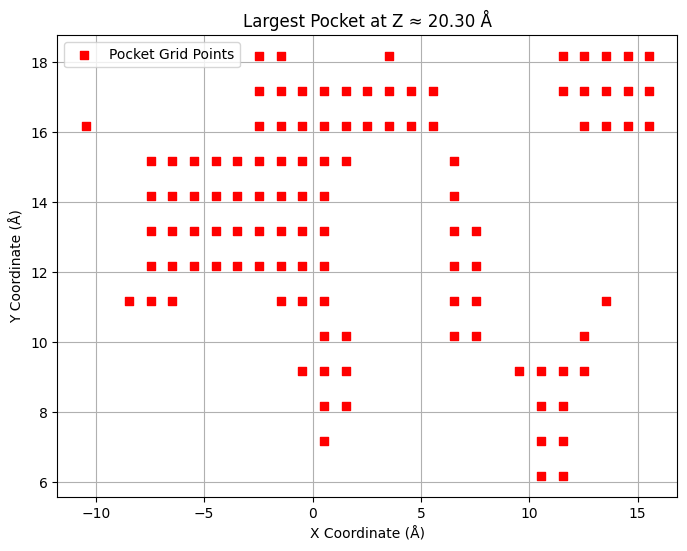

In [ ]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import matplotlib.pyplot as plt

def plot_largest_pocket(pockets, pocket_grid, grid_size, x_min, y_min, z_min):
    """Plot a 2D slice of the largest pocket along the z-axis."""
    if not pockets:
        print("No pockets detected.")
        return

    # Find the largest pocket based on the number of grid points
    largest_pocket = max(pockets, key=len)

    # Convert the pocket grid points into real-world coordinates
    pocket_coords = np.array(largest_pocket)
    x_coords = pocket_coords[:, 0] * grid_size + x_min
    y_coords = pocket_coords[:, 1] * grid_size + y_min
    z_coords = pocket_coords[:, 2] * grid_size + z_min

    # Choose a representative z-slice (median z-value)
    z_slice = np.median(z_coords)
    slice_indices = np.abs(z_coords - z_slice) < grid_size  # Select points close to this z value

    # Extract the x and y values for the chosen z-slice
    x_plot = x_coords[slice_indices]
    y_plot = y_coords[slice_indices]

    # Plot the grid points in the selected z-plane
    plt.figure(figsize=(8, 6))
    plt.scatter(x_plot, y_plot, color="red", marker="s", label="Pocket Grid Points")
    plt.xlabel("X Coordinate (Å)")
    plt.ylabel("Y Coordinate (Å)")
    plt.title(f"Largest Pocket at Z ≈ {z_slice:.2f} Å")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_largest_pocket(pockets, pocket_grid, grid_size, x_min, y_min, z_min)

# Scoring the pockets

### The following one

In [85]:
# The pockets will be scored using the average puntuation (still think if this approach is correct, because I have my doubts)
# Store here the scores
pocket_scoring=[] 
# Generate the scores for each pocket
for entry in range(len(pockets)):
    # As I said, it's the average for teh moment
    pocket_scoring.append(sum(scores[entry])/len(scores[entry]))
# The lists for the scores and the pockets are zipped and then sorted decreasingly 
sorting = sorted(zip(pocket_scoring, pockets), reverse=True)
# Separate the two lists
sorted_scores, sorted_pockets= zip(*sorting)
print(sorted_scores) # Not this, this is just making sure
print(sorted_pockets) # Not this, this is just making sure

(12.636363636363637, 12.0, 11.0, 10.5, 10.5, 9.613065326633166, 9.0, 8.666666666666666, 8.610761705101329, 8.433155080213904, 8.333333333333334, 8.104026845637584, 8.048780487804878, 8.0, 8.0, 8.0, 8.0, 8.0, 7.846153846153846, 7.569429494079656, 7.5625, 7.5, 7.411764705882353, 7.375, 7.375, 7.363636363636363, 7.2272727272727275, 7.128526645768025, 7.0, 7.0, 7.0, 7.0, 6.9748427672955975, 6.954545454545454, 6.833333333333333, 6.8125, 6.8, 6.7, 6.693467336683417, 6.66796875, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.666666666666667, 6.644230769230769, 6.625, 6.622950819672131, 6.583333333333333, 6.5625, 6.5, 6.5, 6.5, 6.375, 6.333333333333333, 6.3, 6.25, 6.153846153846154, 6.052631578947368, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.940298507462686, 5.875, 5.846153846153846, 5.785714285714286, 5.75, 5.714285714285714, 5.666666666666667, 5.666666666666667, 5.66666666666

# Obtaining the nearby atoms

### The following code

In [87]:
# Already defined before, it's redundant
VDW_RADII = {
    "H": 1.1,  # Hydrogen
    "C": 1.6,  # Carbon
    "N": 1.45, # Nitrogen
    "O": 1.42, # Oxygen
    "S": 1.7   # Sulfur (only in Cys & Met)
}

# object that holds the final result that will be printed
results=""
# function to find the near atoms
def nearby_atoms(sorted_pockets, threshold, result, name, hetatoms=False):
    # We will look for each pocket
    for pocket in range(len(sorted_pockets)):
        # With the counter of pockets, we add which place in order is the pocket
        result= result + "Ligand binding site "+ str(pocket+1)+":\n"
        # Object that will store the atoms near the pocket
        atoms=[]
        # we obtain each grid_point in the pocket and obtain the coordinates in the protein
        for grid_point in sorted_pockets[pocket]:
            x= x_min + grid_point[0]*grid_size
            y= y_min + grid_point[1]*grid_size
            z= z_min + grid_point[2]*grid_size
            # we look at each atom, but this is both atoms and heteroatoms, taken into account later
            for atom in structure.get_atoms():
                # In order to see if it is an heteroatom, we need to obtain the residue information
                residue=atom.get_parent()
                # In case they don't want the heteroatoms to be taken into account when detecting ligand biding site:
                if hetatoms == False: 
                    # THe next tests whether the atom is form the protein (ATOM) or not (HETATM), it will only let through those that are from the protein
                    if residue.id[0]== " ":
                        # I basically calculate the length of the vector between the grid_point and the center of the atom, moreover, we again take intoa ccount the atom radius in the distance to more accurately calculate the space between teh grid_point and the atom
                        distance= float((((x-atom.coord[0])**2) + ((y-atom.coord[1])**2) + ((z-atom.coord[2])**2))**0.5) - VDW_RADII.get(atom.element, 1.6)
                        # check if the distance is less than a threshold, I used 4, but others are usign 7, we should find some bibliography to reason why 4.
                        if distance <= threshold:
                            # check the atom is not already in our list to avoid duplicates
                            if [atom.coord[0], atom.coord[1], atom.coord[2]] not in atoms:
                                # add to the list of atoms
                                atoms.append([atom.coord[0], atom.coord[1], atom.coord[2]])
                                # add the information fo the atom
                                res = atom.get_parent()
                                chain = res.get_parent()
                                result = result + f"ATOM {atom.serial_number:5d}  {atom.name:<4}{res.resname:>3} {chain.id}{res.id[1]:4d}    {atom.coord[0]:8.3f}{atom.coord[1]:8.3f}{atom.coord[2]:8.3f}  1.00 {atom.bfactor:6.2f}           {atom.element:>2}\n"
                # The same, but also looking at heteroatoms
                else:
                    distance= float((((x-atom.coord[0])**2) + ((y-atom.coord[1])**2) + ((z-atom.coord[2])**2))**0.5) - VDW_RADII.get(atom.element, 1.6)
                    if distance <= threshold:
                        if [atom.coord[0], atom.coord[1], atom.coord[2]] not in atoms:
                            atoms.append([atom.coord[0], atom.coord[1], atom.coord[2]])
                            res = atom.get_parent()
                            chain = res.get_parent()
                            result = result + f"ATOM {atom.serial_number:5d}  {atom.name:<4}{res.resname:>3} {chain.id}{res.id[1]:4d}    {atom.coord[0]:8.3f}{atom.coord[1]:8.3f}{atom.coord[2]:8.3f}  1.00 {atom.bfactor:6.2f}           {atom.element:>2}\n"
        # add a space line to better visually differentiate the binding sites
        result= result +"\n"
    # print the results
    with open ("Ligand_binding_sites_"+name+".txt","w") as f:
        f.write(result)

nearby_atoms(sorted_pockets, 4.0, results, "1ppb")